# Phân Tích Dự Đoán Giá Chứng Khoán - Logistic Regression Softmax

Notebook này sử dụng **Logistic Regression với Softmax** để phân loại xu hướng giá chứng khoán dựa trên **giá đóng cửa**: **Tăng**, **Giảm**, hoặc **Giữ nguyên**.

## Mục tiêu
- Phân tích dữ liệu từ file CSV đã merge (`data/all_stocks.csv`)
- Tạo features từ dữ liệu giá (returns, moving averages, volatility, etc.)
- Phân loại xu hướng giá đóng cửa: Tăng/Giảm/Giữ nguyên so với ngày trước
- Đánh giá hiệu suất mô hình với các metrics phù hợp


In [24]:
# -*- coding: utf-8 -*-
"""
Import các thư viện cần thiết
"""
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Set encoding
os.environ['PYTHONIOENCODING'] = 'utf-8'

import pandas as pd
import numpy as np
from pathlib import Path
import glob
from tqdm import tqdm

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_recall_fscore_support
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Đã import tất cả thư viện cần thiết")


✅ Đã import tất cả thư viện cần thiết


## 1. Load và Khám Phá Dữ Liệu


In [25]:
# Cấu hình đường dẫn
MERGED_CSV = Path("data/all_stocks.csv")

def load_stock_data_from_csv(csv_path=None, max_rows=None):
    """
    Load dữ liệu từ file CSV đã merge
    
    Args:
        csv_path: Đường dẫn file CSV (mặc định: data/all_stocks.csv)
        max_rows: Giới hạn số dòng để test (None = tất cả)
    
    Returns:
        DataFrame với columns: time, open, high, low, close, volume, symbol
    """
    if csv_path is None:
        csv_path = MERGED_CSV
    
    csv_path = Path(csv_path)
    
    if not csv_path.exists():
        raise FileNotFoundError(f"Không tìm thấy file CSV: {csv_path}")
    
    print(f"📂 Đang đọc từ CSV: {csv_path}")
    print(f"⏳ Vui lòng đợi, file có thể lớn...")
    
    # Đọc CSV với chunking nếu file lớn
    try:
        if max_rows:
            df = pd.read_csv(csv_path, encoding='utf-8-sig', nrows=max_rows)
            print(f"⚠️  Chỉ đọc {max_rows:,} dòng đầu tiên để test")
        else:
            df = pd.read_csv(csv_path, encoding='utf-8-sig')
        
        # Chuyển đổi cột time thành datetime
        if 'time' in df.columns:
            df['time'] = pd.to_datetime(df['time'])
        elif 'date' in df.columns:
            df['time'] = pd.to_datetime(df['date'])
            df = df.drop('date', axis=1)
        
        print(f"✅ Đã load {len(df):,} dòng từ CSV")
        return df
    except Exception as e:
        print(f"❌ Lỗi khi đọc CSV: {e}")
        raise

# Load dữ liệu từ CSV
df = load_stock_data_from_csv()
print(f"\n📊 Thông tin dữ liệu:")
print(f"  - Số dòng: {len(df):,}")
print(f"  - Số mã: {df['symbol'].nunique() if 'symbol' in df.columns else 'N/A'}")
if 'time' in df.columns:
    print(f"  - Khoảng thời gian: {df['time'].min()} đến {df['time'].max()}")
print(f"\n📋 Các cột: {df.columns.tolist()}")
print(f"\n🔍 Mẫu dữ liệu (10 dòng đầu):")
df.head(10)


📂 Đang đọc từ CSV: data\all_stocks.csv
⏳ Vui lòng đợi, file có thể lớn...
✅ Đã load 4,638,725 dòng từ CSV

📊 Thông tin dữ liệu:
  - Số dòng: 4,638,725
  - Số mã: 1692
  - Khoảng thời gian: 2000-07-28 00:00:00 đến 2025-11-10 00:00:00

📋 Các cột: ['time', 'open', 'high', 'low', 'close', 'volume', 'symbol']

🔍 Mẫu dữ liệu (10 dòng đầu):


,time,open,high,low,close,volume,symbol
0,2018-10-23,12.42,0.00,0.00,0.00,0,A32
1,2018-10-24,12.42,12.42,12.42,12.42,0,A32
2,2018-10-25,12.42,12.42,12.42,12.42,0,A32
3,2018-10-26,12.42,12.42,12.42,12.42,0,A32
4,2018-10-29,12.42,12.42,12.42,12.42,0,A32
5,2018-10-30,12.42,12.42,12.42,12.42,0,A32
6,2018-10-31,12.42,12.42,12.42,12.42,0,A32
7,2018-11-01,12.42,12.42,12.42,12.42,0,A32
8,2018-11-02,12.42,12.42,12.42,12.42,0,A32
9,2018-11-05,12.42,12.42,12.42,12.42,0,A32


In [26]:
# Kiểm tra dữ liệu thiếu và chất lượng
print("📊 Thống kê dữ liệu:")
print(df.info())
print("\n📈 Thống kê mô tả:")
print(df[['open', 'high', 'low', 'close', 'volume']].describe())
print("\n🔍 Kiểm tra giá trị thiếu:")
print(df.isnull().sum())
print("\n🔍 Kiểm tra giá trị = 0 (có thể là ngày không giao dịch):")
print((df[['open', 'high', 'low', 'close']] == 0).sum())


📊 Thống kê dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4638725 entries, 0 to 4638724
Data columns (total 7 columns):
 #   Column  Dtype         
---  ------  -----         
 0   time    datetime64[ns]
 1   open    float64       
 2   high    float64       
 3   low     float64       
 4   close   float64       
 5   volume  int64         
 6   symbol  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 247.7+ MB
None

📈 Thống kê mô tả:


               open          high           low         close        volume
count  4.638703e+06  4.638685e+06  4.638685e+06  4.638682e+06  4.638725e+06
mean   1.440194e+01  1.454569e+01  1.423183e+01  1.440223e+01  6.626899e+05
std    4.281227e+01  4.312382e+01  4.246097e+01  4.280478e+01  1.376244e+07
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
25%    4.390000e+00  4.410000e+00  4.300000e+00  4.380000e+00  0.000000e+00
50%    8.200000e+00  8.280000e+00  8.100000e+00  8.200000e+00  2.000000e+03
75%    1.482000e+01  1.500000e+01  1.463000e+01  1.483000e+01  4.840000e+04
max    2.036900e+03  2.055850e+03  2.004240e+03  2.022270e+03  2.698902e+09

🔍 Kiểm tra giá trị thiếu:
time       0
open      22
high      40
low       40
close     43
volume     0
symbol     0
dtype: int64

🔍 Kiểm tra giá trị = 0 (có thể là ngày không giao dịch):
open      1148
high     10909
low      10910
close    11203
dtype: int64


## 2. Tiền Xử Lý Dữ Liệu

In [27]:
def preprocess_data(df, min_volume=0, remove_zero_price=True):
    """
    Tiền xử lý dữ liệu: loại bỏ dữ liệu không hợp lệ
    
    Args:
        df: DataFrame gốc
        min_volume: Khối lượng giao dịch tối thiểu
        remove_zero_price: Có loại bỏ dòng có giá = 0 không
    
    Returns:
        DataFrame đã được làm sạch
    """
    df_clean = df.copy()
    
    # Loại bỏ dòng có giá = 0 (ngày không giao dịch)
    if remove_zero_price:
        before = len(df_clean)
        df_clean = df_clean[
            (df_clean['open'] > 0) & 
            (df_clean['close'] > 0) &
            (df_clean['high'] > 0) &
            (df_clean['low'] > 0)
        ]
        print(f"🗑️  Đã loại bỏ {before - len(df_clean):,} dòng có giá = 0")
    
    # Loại bỏ dòng có volume < min_volume
    if min_volume > 0:
        before = len(df_clean)
        df_clean = df_clean[df_clean['volume'] >= min_volume]
        print(f"🗑️  Đã loại bỏ {before - len(df_clean):,} dòng có volume < {min_volume}")
    
    # Sắp xếp lại theo symbol và time
    df_clean = df_clean.sort_values(['symbol', 'time']).reset_index(drop=True)
    
    print(f"✅ Dữ liệu sau khi làm sạch: {len(df_clean):,} dòng")
    return df_clean

# Làm sạch dữ liệu
df_clean = preprocess_data(df, min_volume=0, remove_zero_price=True)
print(f"\n📊 Số mã còn lại: {df_clean['symbol'].nunique()}")


🗑️  Đã loại bỏ 11,285 dòng có giá = 0
✅ Dữ liệu sau khi làm sạch: 4,627,440 dòng

📊 Số mã còn lại: 1692


## 3. Feature Engineering và Tạo Target Variable

Tạo các features từ dữ liệu giá và target variable dựa trên **giá đóng cửa**:
- **Tăng**: Giá đóng cửa hôm nay > giá đóng cửa hôm qua
- **Giảm**: Giá đóng cửa hôm nay < giá đóng cửa hôm qua  
- **Giữ nguyên**: Giá đóng cửa hôm nay = giá đóng cửa hôm qua


In [28]:
def create_features_and_target(df, threshold_pct=0.001):
    """
    Tạo features và target variable từ dữ liệu giá
    
    Args:
        df: DataFrame đã được làm sạch
        threshold_pct: Ngưỡng phần trăm để coi là "giữ nguyên" (mặc định 0.1%)
    
    Returns:
        DataFrame với features và target variable
    """
    df_feat = df.copy()
    
    # Đảm bảo sắp xếp theo symbol và time
    df_feat = df_feat.sort_values(['symbol', 'time']).reset_index(drop=True)
    
    print("🔧 Đang tạo features...")
    
    # 1. Returns (tỷ suất sinh lời)
    df_feat['return_1d'] = df_feat.groupby('symbol')['close'].pct_change(1)  # 1 ngày
    df_feat['return_2d'] = df_feat.groupby('symbol')['close'].pct_change(2)  # 2 ngày
    df_feat['return_5d'] = df_feat.groupby('symbol')['close'].pct_change(5)  # 5 ngày
    df_feat['return_10d'] = df_feat.groupby('symbol')['close'].pct_change(10)  # 10 ngày
    
    # 2. Moving Averages
    df_feat['ma5'] = df_feat.groupby('symbol')['close'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
    df_feat['ma10'] = df_feat.groupby('symbol')['close'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())
    df_feat['ma20'] = df_feat.groupby('symbol')['close'].transform(lambda x: x.rolling(window=20, min_periods=1).mean())
    df_feat['ma50'] = df_feat.groupby('symbol')['close'].transform(lambda x: x.rolling(window=50, min_periods=1).mean())
    
    # 3. Price relative to MA
    df_feat['price_ma5_ratio'] = df_feat['close'] / df_feat['ma5'] - 1
    df_feat['price_ma10_ratio'] = df_feat['close'] / df_feat['ma10'] - 1
    df_feat['price_ma20_ratio'] = df_feat['close'] / df_feat['ma20'] - 1
    
    # 4. Volatility (độ biến động)
    df_feat['volatility_5d'] = df_feat.groupby('symbol')['return_1d'].transform(lambda x: x.rolling(window=5, min_periods=1).std())
    df_feat['volatility_10d'] = df_feat.groupby('symbol')['return_1d'].transform(lambda x: x.rolling(window=10, min_periods=1).std())
    df_feat['volatility_20d'] = df_feat.groupby('symbol')['return_1d'].transform(lambda x: x.rolling(window=20, min_periods=1).std())
    
    # 5. High-Low range
    df_feat['hl_range'] = (df_feat['high'] - df_feat['low']) / df_feat['close']
    df_feat['hl_range_5d_avg'] = df_feat.groupby('symbol')['hl_range'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
    
    # 6. Volume features
    df_feat['volume_ma5'] = df_feat.groupby('symbol')['volume'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
    df_feat['volume_ma10'] = df_feat.groupby('symbol')['volume'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())
    df_feat['volume_ratio'] = df_feat['volume'] / (df_feat['volume_ma5'] + 1e-6)  # Tránh chia 0
    
    # 7. Price position trong ngày (Body/Shadow)
    df_feat['body'] = abs(df_feat['close'] - df_feat['open']) / df_feat['close']
    df_feat['upper_shadow'] = (df_feat['high'] - df_feat[['open', 'close']].max(axis=1)) / df_feat['close']
    df_feat['lower_shadow'] = (df_feat[['open', 'close']].min(axis=1) - df_feat['low']) / df_feat['close']
    
    # 8. RSI-like indicator (Relative Strength)
    df_feat['price_change'] = df_feat.groupby('symbol')['close'].diff(1)
    df_feat['gain'] = df_feat['price_change'].clip(lower=0)
    df_feat['loss'] = -df_feat['price_change'].clip(upper=0)
    df_feat['avg_gain_5d'] = df_feat.groupby('symbol')['gain'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
    df_feat['avg_loss_5d'] = df_feat.groupby('symbol')['loss'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
    df_feat['rs'] = df_feat['avg_gain_5d'] / (df_feat['avg_loss_5d'] + 1e-6)
    
    # 9. Tạo TARGET VARIABLE dựa trên giá đóng cửa
    # So sánh giá đóng cửa hôm nay với hôm qua
    df_feat['prev_close'] = df_feat.groupby('symbol')['close'].shift(1)
    df_feat['close_change'] = df_feat['close'] - df_feat['prev_close']
    df_feat['close_change_pct'] = df_feat['close_change'] / (df_feat['prev_close'] + 1e-6)
    
    # Phân loại: 0 = Giảm, 1 = Giữ nguyên, 2 = Tăng
    conditions = [
        df_feat['close_change_pct'] < -threshold_pct,  # Giảm
        (df_feat['close_change_pct'] >= -threshold_pct) & (df_feat['close_change_pct'] <= threshold_pct),  # Giữ nguyên
        df_feat['close_change_pct'] > threshold_pct  # Tăng
    ]
    choices = [0, 1, 2]  # 0: Giảm, 1: Giữ nguyên, 2: Tăng
    df_feat['target'] = np.select(conditions, choices, default=1)
    
    # Loại bỏ các dòng không có dữ liệu đủ để tính features (dòng đầu tiên của mỗi symbol)
    df_feat = df_feat.dropna(subset=['prev_close']).reset_index(drop=True)
    
    print(f"✅ Đã tạo {len([c for c in df_feat.columns if c not in df.columns])} features mới")
    print(f"✅ Đã tạo target variable: {df_feat['target'].value_counts().to_dict()}")
    
    return df_feat

# Tạo features và target
df_features = create_features_and_target(df_clean, threshold_pct=0.001)
print(f"\n📊 Số dòng sau khi tạo features: {len(df_features):,}")
print(f"\n📋 Các features đã tạo:")
feature_cols = [c for c in df_features.columns if c not in ['time', 'open', 'high', 'low', 'close', 'volume', 'symbol', 'target', 'prev_close', 'close_change', 'close_change_pct']]
print(f"  - {len(feature_cols)} features: {', '.join(feature_cols[:10])}...")


🔧 Đang tạo features...
✅ Đã tạo 32 features mới
✅ Đã tạo target variable: {1: 2100831, 0: 1273237, 2: 1251680}

📊 Số dòng sau khi tạo features: 4,625,748

📋 Các features đã tạo:
  - 28 features: return_1d, return_2d, return_5d, return_10d, ma5, ma10, ma20, ma50, price_ma5_ratio, price_ma10_ratio...


📊 Phân phối Target Variable:
  - Giảm (class 0): 1,273,237 (27.52%)
  - Giữ nguyên (class 1): 2,100,831 (45.42%)
  - Tăng (class 2): 1,251,680 (27.06%)


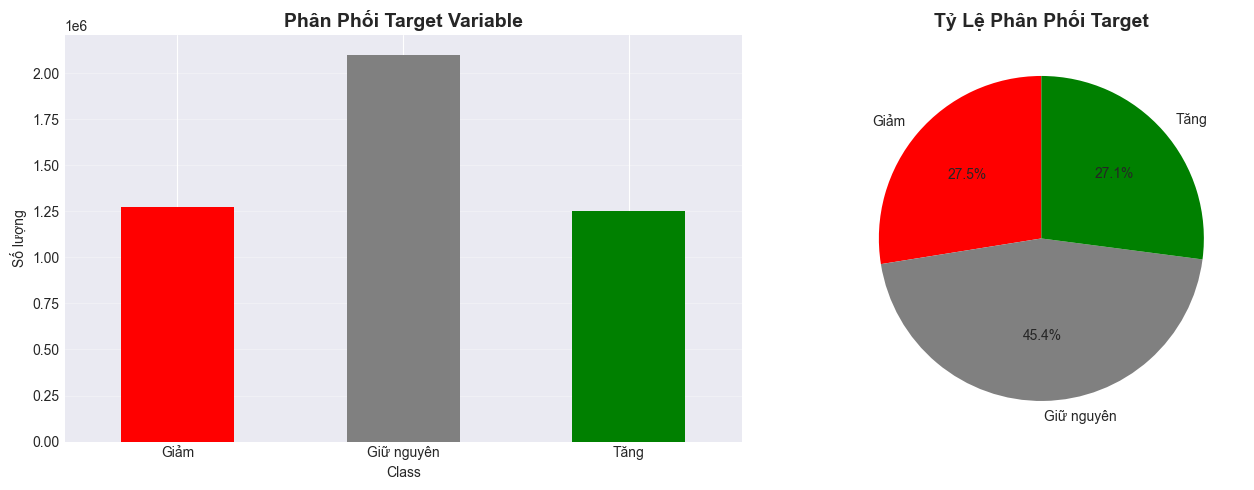

In [29]:
# Phân tích phân phối target
print("📊 Phân phối Target Variable:")
target_counts = df_features['target'].value_counts().sort_index()
target_labels = {0: 'Giảm', 1: 'Giữ nguyên', 2: 'Tăng'}
for target_val, count in target_counts.items():
    pct = count / len(df_features) * 100
    print(f"  - {target_labels[target_val]} (class {target_val}): {count:,} ({pct:.2f}%)")

# Visualize phân phối
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
target_counts.plot(kind='bar', ax=axes[0], color=['red', 'gray', 'green'])
axes[0].set_title('Phân Phối Target Variable', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Số lượng')
axes[0].set_xticklabels([target_labels[i] for i in target_counts.index], rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
axes[1].pie(target_counts.values, labels=[target_labels[i] for i in target_counts.index], 
            autopct='%1.1f%%', colors=['red', 'gray', 'green'], startangle=90)
axes[1].set_title('Tỷ Lệ Phân Phối Target', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


## 4. Chuẩn Bị Dữ Liệu Cho Model


In [30]:
# Chọn features để train (loại bỏ các cột không phải feature)
exclude_cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'symbol', 
                'target', 'prev_close', 'close_change', 'close_change_pct',
                'price_change', 'gain', 'loss']  # Loại bỏ các cột trung gian

feature_cols = [c for c in df_features.columns if c not in exclude_cols]

print(f"📋 Số lượng features: {len(feature_cols)}")
print(f"📋 Features: {feature_cols}")

# Tạo X và y
X = df_features[feature_cols].copy()
y = df_features['target'].copy()

# Loại bỏ các dòng có giá trị NaN hoặc Inf
print(f"\n🔍 Kiểm tra dữ liệu:")
print(f"  - Số dòng ban đầu: {len(X):,}")
print(f"  - Số dòng có NaN: {X.isnull().any(axis=1).sum():,}")
print(f"  - Số dòng có Inf: {np.isinf(X).any(axis=1).sum():,}")

# Loại bỏ NaN và Inf
valid_mask = ~(X.isnull().any(axis=1) | np.isinf(X).any(axis=1))
X = X[valid_mask].reset_index(drop=True)
y = y[valid_mask].reset_index(drop=True)

print(f"  - Số dòng sau khi loại bỏ NaN/Inf: {len(X):,}")

# Train/Test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n📊 Chia dữ liệu:")
print(f"  - Train: {len(X_train):,} dòng ({len(X_train)/len(X)*100:.1f}%)")
print(f"  - Test: {len(X_test):,} dòng ({len(X_test)/len(X)*100:.1f}%)")

# Chuẩn hóa dữ liệu (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Đã chuẩn hóa dữ liệu với StandardScaler")


📋 Số lượng features: 25
📋 Features: ['return_1d', 'return_2d', 'return_5d', 'return_10d', 'ma5', 'ma10', 'ma20', 'ma50', 'price_ma5_ratio', 'price_ma10_ratio', 'price_ma20_ratio', 'volatility_5d', 'volatility_10d', 'volatility_20d', 'hl_range', 'hl_range_5d_avg', 'volume_ma5', 'volume_ma10', 'volume_ratio', 'body', 'upper_shadow', 'lower_shadow', 'avg_gain_5d', 'avg_loss_5d', 'rs']

🔍 Kiểm tra dữ liệu:
  - Số dòng ban đầu: 4,625,748
  - Số dòng có NaN: 15,172
  - Số dòng có Inf: 0
  - Số dòng sau khi loại bỏ NaN/Inf: 4,610,576

📊 Chia dữ liệu:
  - Train: 3,688,460 dòng (80.0%)
  - Test: 922,116 dòng (20.0%)
✅ Đã chuẩn hóa dữ liệu với StandardScaler


## 5. Train Logistic Regression với Softmax


In [31]:
# Tạo và train Logistic Regression với softmax (multinomial)
# multi_class='multinomial' sử dụng softmax
print("🚀 Đang train Logistic Regression với Softmax...")
print("⏳ Vui lòng đợi, có thể mất vài phút...")

model = LogisticRegression(
    multi_class='multinomial',  # Sử dụng softmax
    solver='lbfgs',  # LBFGS phù hợp cho multinomial
    max_iter=1000,
    random_state=42,
    n_jobs=-1,  # Sử dụng tất cả CPU cores
    verbose=1
)

model.fit(X_train_scaled, y_train)

print("✅ Đã train xong model!")
print(f"\n📊 Thông tin model:")
print(f"  - Số classes: {len(model.classes_)}")
print(f"  - Classes: {model.classes_}")
print(f"  - Số features: {model.n_features_in_}")


🚀 Đang train Logistic Regression với Softmax...
⏳ Vui lòng đợi, có thể mất vài phút...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


✅ Đã train xong model!

📊 Thông tin model:
  - Số classes: 3
  - Classes: [0 1 2]
  - Số features: 25


## 6. Đánh Giá Model


📊 KẾT QUẢ ĐÁNH GIÁ MODEL

✅ Accuracy:
  - Train: 0.9971 (99.71%)
  - Test: 0.9971 (99.71%)

📋 Classification Report - Test Set:
              precision    recall  f1-score   support

        Giảm     0.9998    0.9949    0.9974    253620
  Giữ nguyên     0.9939    0.9998    0.9968    419066
        Tăng     0.9998    0.9948    0.9973    249430

    accuracy                         0.9971    922116
   macro avg     0.9979    0.9965    0.9972    922116
weighted avg     0.9971    0.9971    0.9971    922116


📊 Confusion Matrix - Test Set:
[[252335   1285      0]
 [    40 418984     42]
 [     1   1288 248141]]


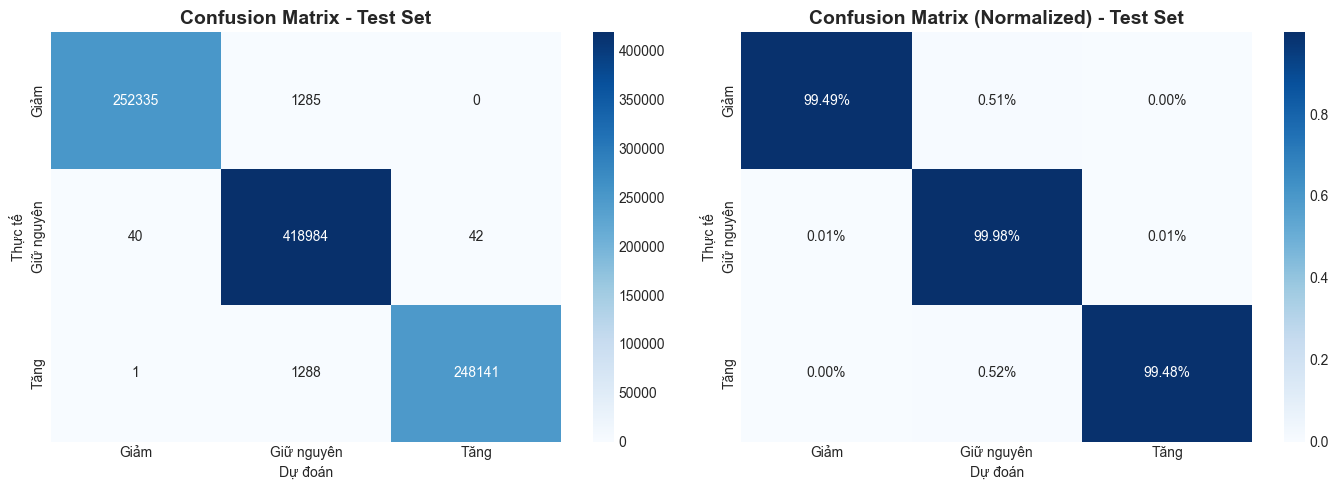

In [32]:
# Dự đoán trên tập train và test
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Dự đoán xác suất
y_train_proba = model.predict_proba(X_train_scaled)
y_test_proba = model.predict_proba(X_test_scaled)

# Tính các metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("=" * 60)
print("📊 KẾT QUẢ ĐÁNH GIÁ MODEL")
print("=" * 60)

print(f"\n✅ Accuracy:")
print(f"  - Train: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"  - Test: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Classification report
print(f"\n📋 Classification Report - Test Set:")
target_names = [target_labels[i] for i in sorted(model.classes_)]
print(classification_report(y_test, y_test_pred, target_names=target_names, digits=4))

# Confusion Matrix
print(f"\n📊 Confusion Matrix - Test Set:")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)

# Visualize Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=target_names, yticklabels=target_names)
axes[0].set_title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Thực tế')
axes[0].set_xlabel('Dự đoán')

# Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[1],
            xticklabels=target_names, yticklabels=target_names)
axes[1].set_title('Confusion Matrix (Normalized) - Test Set', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Thực tế')
axes[1].set_xlabel('Dự đoán')

plt.tight_layout()
plt.show()


## 6. Phân Tích Accuracy


In [33]:
# Phân tích chi tiết từng class
print("\n📊 Phân Tích Chi Tiết Từng Class:")

# Tính metrics cho tất cả classes một lần
precision_all, recall_all, f1_all, support_all = precision_recall_fscore_support(
    y_test, y_test_pred, labels=None, average=None, zero_division=0
)

# Tạo mapping từ class index đến vị trí trong kết quả
class_to_pos = {class_idx: pos for pos, class_idx in enumerate(sorted(model.classes_))}

for i, class_name in enumerate(target_names):
    class_idx = sorted(model.classes_)[i]
    pos = class_to_pos[class_idx]
    
    print(f"\n{class_name} (Class {class_idx}):")
    print(f"  - Precision: {precision_all[pos]:.4f}")
    print(f"  - Recall: {recall_all[pos]:.4f}")
    print(f"  - F1-Score: {f1_all[pos]:.4f}")
    print(f"  - Support: {support_all[pos]:,} mẫu")



📊 Phân Tích Chi Tiết Từng Class:

Giảm (Class 0):
  - Precision: 0.9998
  - Recall: 0.9949
  - F1-Score: 0.9974
  - Support: 253,620 mẫu

Giữ nguyên (Class 1):
  - Precision: 0.9939
  - Recall: 0.9998
  - F1-Score: 0.9968
  - Support: 419,066 mẫu

Tăng (Class 2):
  - Precision: 0.9998
  - Recall: 0.9948
  - F1-Score: 0.9973
  - Support: 249,430 mẫu


## 7. Phân Tích Feature Importance


📊 Top 20 Features Quan Trọng Nhất (theo absolute coefficient):
------------------------------------------------------------
 1. return_1d                      : 128.623439
 2. rs                             : 11.751038
 3. price_ma10_ratio               : 0.600980
 4. upper_shadow                   : 0.436592
 5. body                           : 0.436362
 6. volatility_20d                 : 0.422792
 7. hl_range_5d_avg                : 0.324965
 8. price_ma5_ratio                : 0.278197
 9. return_10d                     : 0.237639
10. ma50                           : 0.206076
11. volume_ratio                   : 0.194643
12. return_5d                      : 0.192118
13. volatility_10d                 : 0.146221
14. volatility_5d                  : 0.116272
15. hl_range                       : 0.090901
16. price_ma20_ratio               : 0.079704
17. ma5                            : 0.074186
18. volume_ma10                    : 0.071637
19. ma10                           : 0.066374

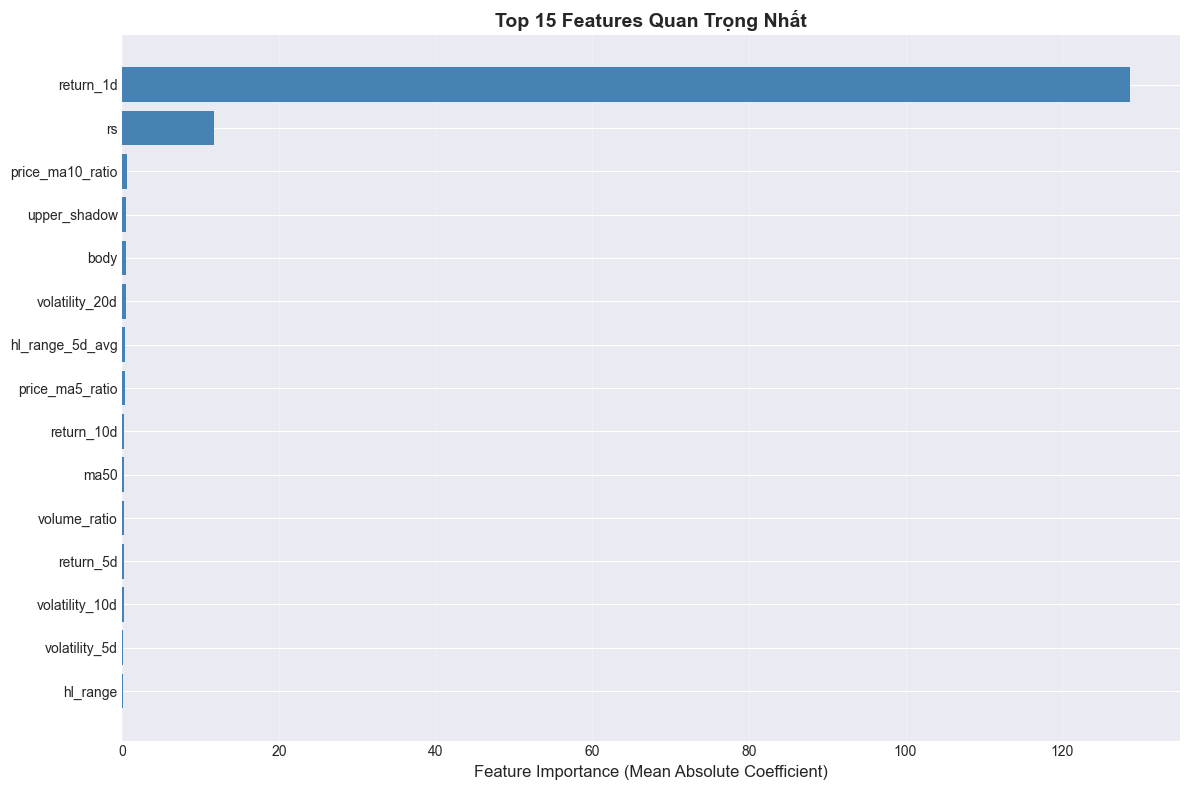

In [34]:
# Feature importance từ coefficients của Logistic Regression
# Với multinomial, có coefficients cho mỗi class
feature_importance = {}

for i, class_idx in enumerate(sorted(model.classes_)):
    class_name = target_labels[class_idx]
    coef = model.coef_[i]
    feature_importance[class_name] = dict(zip(feature_cols, coef))

# Tính absolute importance (trung bình absolute value của coefficients)
abs_importance = {}
for feat in feature_cols:
    abs_importance[feat] = np.mean([abs(feature_importance[class_name][feat]) 
                                    for class_name in target_names])

# Sắp xếp theo importance
sorted_features = sorted(abs_importance.items(), key=lambda x: x[1], reverse=True)

print("📊 Top 20 Features Quan Trọng Nhất (theo absolute coefficient):")
print("-" * 60)
for i, (feat, importance) in enumerate(sorted_features[:20], 1):
    print(f"{i:2d}. {feat:30s} : {importance:.6f}")

# Visualize top features
top_n = 15
top_features = [f[0] for f in sorted_features[:top_n]]
top_importance = [f[1] for f in sorted_features[:top_n]]

fig, ax = plt.subplots(figsize=(12, 8))
y_pos = np.arange(len(top_features))
ax.barh(y_pos, top_importance, color='steelblue')
ax.set_yticks(y_pos)
ax.set_yticklabels(top_features)
ax.invert_yaxis()
ax.set_xlabel('Feature Importance (Mean Absolute Coefficient)', fontsize=12)
ax.set_title(f'Top {top_n} Features Quan Trọng Nhất', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


## 8. Phân Tích Dự Đoán Trên Một Số Mã Cụ Thể


In [35]:
# Chọn một số mã để phân tích chi tiết
sample_symbols = df_features['symbol'].value_counts().head(5).index.tolist()

print("📊 Phân Tích Dự Đoán Trên Một Số Mã Cụ Thể:")
print("=" * 60)

for symbol in sample_symbols:
    symbol_data = df_features[df_features['symbol'] == symbol].copy()
    if len(symbol_data) < 10:
        continue
    
    # Lấy features và target
    X_symbol = symbol_data[feature_cols].copy()
    y_symbol = symbol_data['target'].copy()
    
    # Loại bỏ NaN/Inf
    valid_mask = ~(X_symbol.isnull().any(axis=1) | np.isinf(X_symbol).any(axis=1))
    X_symbol = X_symbol[valid_mask]
    y_symbol = y_symbol[valid_mask]
    
    if len(X_symbol) == 0:
        continue
    
    # Chuẩn hóa và dự đoán
    X_symbol_scaled = scaler.transform(X_symbol)
    y_symbol_pred = model.predict(X_symbol_scaled)
    y_symbol_proba = model.predict_proba(X_symbol_scaled)
    
    # Tính accuracy cho mã này
    symbol_accuracy = accuracy_score(y_symbol, y_symbol_pred)
    
    print(f"\n📈 Mã: {symbol}")
    print(f"  - Số ngày giao dịch: {len(X_symbol):,}")
    print(f"  - Accuracy: {symbol_accuracy:.4f} ({symbol_accuracy*100:.2f}%)")
    print(f"  - Phân phối thực tế: {dict(y_symbol.value_counts().sort_index())}")
    print(f"  - Phân phối dự đoán: {dict(pd.Series(y_symbol_pred).value_counts().sort_index())}")
    
    # Hiển thị một số dự đoán mẫu
    print(f"  - Mẫu dự đoán (5 dòng cuối):")
    sample_indices = symbol_data[valid_mask].tail(5).index
    for idx in sample_indices:
        if idx in symbol_data.index:
            row = symbol_data.loc[idx]
            pred_idx = list(symbol_data[valid_mask].index).index(idx)
            actual = target_labels[y_symbol.iloc[pred_idx]]
            predicted = target_labels[y_symbol_pred[pred_idx]]
            proba = y_symbol_proba[pred_idx]
            print(f"    {row['time'].strftime('%Y-%m-%d')}: Thực tế={actual}, Dự đoán={predicted}, "
                  f"Xác suất=[Giảm:{proba[0]:.2%}, Giữ:{proba[1]:.2%}, Tăng:{proba[2]:.2%}]")


📊 Phân Tích Dự Đoán Trên Một Số Mã Cụ Thể:

📈 Mã: REE
  - Số ngày giao dịch: 6,140
  - Accuracy: 0.9927 (99.27%)
  - Phân phối thực tế: {0: np.int64(2574), 1: np.int64(974), 2: np.int64(2592)}
  - Phân phối dự đoán: {0: np.int64(2552), 1: np.int64(1019), 2: np.int64(2569)}
  - Mẫu dự đoán (5 dòng cuối):
    2025-11-03: Thực tế=Giảm, Dự đoán=Giảm, Xác suất=[Giảm:100.00%, Giữ:0.00%, Tăng:0.00%]
    2025-11-04: Thực tế=Giữ nguyên, Dự đoán=Giữ nguyên, Xác suất=[Giảm:1.24%, Giữ:97.88%, Tăng:0.89%]
    2025-11-05: Thực tế=Tăng, Dự đoán=Tăng, Xác suất=[Giảm:0.00%, Giữ:0.37%, Tăng:99.63%]
    2025-11-06: Thực tế=Giảm, Dự đoán=Giảm, Xác suất=[Giảm:62.50%, Giữ:37.50%, Tăng:0.00%]
    2025-11-07: Thực tế=Giảm, Dự đoán=Giảm, Xác suất=[Giảm:100.00%, Giữ:0.00%, Tăng:0.00%]

📈 Mã: SAM
  - Số ngày giao dịch: 6,140
  - Accuracy: 0.9914 (99.14%)
  - Phân phối thực tế: {0: np.int64(2548), 1: np.int64(1178), 2: np.int64(2414)}
  - Phân phối dự đoán: {0: np.int64(2519), 1: np.int64(1231), 2: np.int64(2390)

## 9. Dự Đoán Theo Chu Kỳ Thời Gian

Phân tích và dự đoán xu hướng giá theo các chu kỳ thời gian:
- **Tuần**: So sánh giá cuối tuần với đầu tuần
- **Tháng**: So sánh giá cuối tháng với đầu tháng  
- **Quý**: So sánh giá cuối quý với đầu quý
- **Năm**: So sánh giá cuối năm với đầu năm


In [ ]:
# Tạo target variables theo chu kỳ thời gian
print("=" * 60)
print("📅 TẠO TARGET VARIABLES THEO CHU KỲ THỜI GIAN")
print("=" * 60)

# Sử dụng df_features (đã có features) thay vì df_clean
# Đảm bảo dữ liệu đã được sắp xếp
df_cycle = df_features.sort_values(['symbol', 'time']).reset_index(drop=True).copy()

# Thêm các cột thời gian
df_cycle['year'] = df_cycle['time'].dt.year
df_cycle['quarter'] = df_cycle['time'].dt.quarter
df_cycle['month'] = df_cycle['time'].dt.month
df_cycle['year_week'] = df_cycle['time'].dt.strftime('%Y-W%V')

print("\n🔧 Đang tạo target variables...")

# Hàm helper để tạo target cho một chu kỳ
def create_target_for_period(df, group_cols, threshold_pct, target_name):
    """Tạo target variable cho một chu kỳ cụ thể"""
    if isinstance(group_cols, list):
        grouped = df.groupby(['symbol'] + group_cols)
    else:
        grouped = df.groupby(['symbol', group_cols])
    
    period_data = []
    for key, group in grouped:
        if len(group) == 0:
            continue
        
        # Xử lý key từ groupby
        if isinstance(group_cols, list):
            symbol = key[0]
            period_keys = key[1:]
            period_dict = {col: val for col, val in zip(group_cols, period_keys)}
        else:
            symbol, period_key = key
            period_dict = {group_cols: period_key}
        
        start_close = group['close'].iloc[0]
        end_close = group['close'].iloc[-1]
        change_pct = (end_close - start_close) / (start_close + 1e-6)
        
        # Tạo target: 0 = Giảm, 1 = Giữ nguyên, 2 = Tăng
        if change_pct < -threshold_pct:
            target = 0
        elif change_pct > threshold_pct:
            target = 2
        else:
            target = 1
        
        period_data.append({
            'symbol': symbol,
            **period_dict,
            f'target_{target_name}': target,
            f'change_{target_name}_pct': change_pct
        })
    
    return pd.DataFrame(period_data)

# Tạo target cho từng chu kỳ
# Tuần
print("  - Đang tạo target cho Tuần...")
week_df = create_target_for_period(df_cycle, 'year_week', 0.01, 'week')
df_cycle = df_cycle.merge(week_df[['symbol', 'year_week', 'target_week', 'change_week_pct']], 
                          on=['symbol', 'year_week'], how='left')

# Tháng
print("  - Đang tạo target cho Tháng...")
month_df = create_target_for_period(df_cycle, ['year', 'month'], 0.02, 'month')
df_cycle = df_cycle.merge(month_df[['symbol', 'year', 'month', 'target_month', 'change_month_pct']], 
                          on=['symbol', 'year', 'month'], how='left')

# Quý
print("  - Đang tạo target cho Quý...")
quarter_df = create_target_for_period(df_cycle, ['year', 'quarter'], 0.05, 'quarter')
df_cycle = df_cycle.merge(quarter_df[['symbol', 'year', 'quarter', 'target_quarter', 'change_quarter_pct']], 
                          on=['symbol', 'year', 'quarter'], how='left')

# Năm
print("  - Đang tạo target cho Năm...")
year_df = create_target_for_period(df_cycle, 'year', 0.10, 'year')
df_cycle = df_cycle.merge(year_df[['symbol', 'year', 'target_year', 'change_year_pct']], 
                          on=['symbol', 'year'], how='left')

# Thống kê phân phối target
print("\n📊 Phân Phối Target Theo Chu Kỳ:")
target_labels = {0: 'Giảm', 1: 'Giữ nguyên', 2: 'Tăng'}

for period_name, target_col in [
    ('Tuần', 'target_week'),
    ('Tháng', 'target_month'),
    ('Quý', 'target_quarter'),
    ('Năm', 'target_year')
]:
    if target_col in df_cycle.columns:
        target_dist = df_cycle[target_col].value_counts().sort_index()
        total = len(df_cycle[df_cycle[target_col].notna()])
        print(f"\n{period_name}:")
        for class_idx, count in target_dist.items():
            pct = count / total * 100 if total > 0 else 0
            print(f"  - {target_labels[class_idx]}: {count:,} ({pct:.2f}%)")

print("\n✅ Đã tạo target variables cho tất cả chu kỳ!")


📅 TẠO TARGET VARIABLES THEO CHU KỲ THỜI GIAN

🔧 Đang tạo target variables...
  - Đang tạo target cho Tuần...
  - Đang tạo target cho Tháng...
  - Đang tạo target cho Quý...
  - Đang tạo target cho Năm...

📊 Phân Phối Target Theo Chu Kỳ:

Tuần:
  - Giảm: 1,390,810 (30.07%)
  - Giữ nguyên: 1,806,203 (39.05%)
  - Tăng: 1,428,735 (30.89%)

Tháng:
  - Giảm: 1,670,976 (36.12%)
  - Giữ nguyên: 1,294,283 (27.98%)
  - Tăng: 1,660,489 (35.90%)

Quý:
  - Giảm: 1,576,281 (34.08%)
  - Giữ nguyên: 1,346,208 (29.10%)
  - Tăng: 1,703,259 (36.82%)

Năm:
  - Giảm: 1,506,311 (32.56%)
  - Giữ nguyên: 1,088,237 (23.53%)
  - Tăng: 2,031,200 (43.91%)

✅ Đã tạo target variables cho tất cả chu kỳ!


In [40]:
# Train và đánh giá model cho từng chu kỳ
print("=" * 60)
print("🤖 TRAIN VÀ ĐÁNH GIÁ MODEL THEO CHU KỲ")
print("=" * 60)

# Sử dụng cùng feature_cols như model chính
results_by_cycle = {}

for period_name, target_col in [
    ('Tuần', 'target_week'),
    ('Tháng', 'target_month'),
    ('Quý', 'target_quarter'),
    ('Năm', 'target_year')
]:
    if target_col not in df_cycle.columns:
        continue
    
    print(f"\n{'='*60}")
    print(f"📊 Chu Kỳ: {period_name}")
    print(f"{'='*60}")
    
    # Lọc dữ liệu có target
    df_valid = df_cycle[df_cycle[target_col].notna()].copy()
    
    if len(df_valid) == 0:
        print(f"⚠️  Không có dữ liệu cho {period_name}")
        continue
    
    # Chuẩn bị dữ liệu
    X = df_valid[feature_cols].copy()
    y = df_valid[target_col].copy()
    
    # Loại bỏ NaN/Inf
    valid_mask = ~(X.isnull().any(axis=1) | np.isinf(X).any(axis=1))
    X = X[valid_mask]
    y = y[valid_mask]
    
    if len(X) == 0:
        print(f"⚠️  Không đủ dữ liệu hợp lệ để train model cho {period_name}")
        continue
    
    # Chia train/test
    try:
        X_train_cycle, X_test_cycle, y_train_cycle, y_test_cycle = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
    except ValueError:
        # Nếu không thể stratify (quá ít mẫu cho một class), dùng random split
        X_train_cycle, X_test_cycle, y_train_cycle, y_test_cycle = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
    
    # Chuẩn hóa
    scaler_cycle = StandardScaler()
    X_train_scaled_cycle = scaler_cycle.fit_transform(X_train_cycle)
    X_test_scaled_cycle = scaler_cycle.transform(X_test_cycle)
    
    # Train model
    model_cycle = LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        random_state=42,
        n_jobs=-1
    )
    model_cycle.fit(X_train_scaled_cycle, y_train_cycle)
    
    # Dự đoán
    y_train_pred_cycle = model_cycle.predict(X_train_scaled_cycle)
    y_test_pred_cycle = model_cycle.predict(X_test_scaled_cycle)
    
    # Đánh giá
    train_acc_cycle = accuracy_score(y_train_cycle, y_train_pred_cycle)
    test_acc_cycle = accuracy_score(y_test_cycle, y_test_pred_cycle)
    
    # Lưu kết quả
    results_by_cycle[period_name] = {
        'model': model_cycle,
        'scaler': scaler_cycle,
        'train_accuracy': train_acc_cycle,
        'test_accuracy': test_acc_cycle,
        'y_test': y_test_cycle,
        'y_test_pred': y_test_pred_cycle,
        'n_samples': len(X),
        'n_train': len(X_train_cycle),
        'n_test': len(X_test_cycle)
    }
    
    print(f"✅ Train Accuracy: {train_acc_cycle:.4f} ({train_acc_cycle*100:.2f}%)")
    print(f"✅ Test Accuracy: {test_acc_cycle:.4f} ({test_acc_cycle*100:.2f}%)")
    print(f"📊 Số mẫu: {len(X):,} (Train: {len(X_train_cycle):,}, Test: {len(X_test_cycle):,})")
    
    # Classification report
    print(f"\n📋 Classification Report - {period_name}:")
    target_names_cycle = [target_labels[i] for i in sorted(y_test_cycle.unique())]
    print(classification_report(
        y_test_cycle, 
        y_test_pred_cycle, 
        target_names=target_names_cycle,
        digits=4
    ))

print(f"\n✅ Đã train và đánh giá model cho {len(results_by_cycle)} chu kỳ!")


🤖 TRAIN VÀ ĐÁNH GIÁ MODEL THEO CHU KỲ

📊 Chu Kỳ: Tuần
✅ Train Accuracy: 0.5861 (58.61%)
✅ Test Accuracy: 0.5865 (58.65%)
📊 Số mẫu: 4,610,576 (Train: 3,688,460, Test: 922,116)

📋 Classification Report - Tuần:
              precision    recall  f1-score   support

        Giảm     0.5801    0.4658    0.5167    276997
  Giữ nguyên     0.5916    0.7584    0.6647    360252
        Tăng     0.5827    0.4865    0.5303    284867

    accuracy                         0.5865    922116
   macro avg     0.5848    0.5702    0.5706    922116
weighted avg     0.5854    0.5865    0.5787    922116


📊 Chu Kỳ: Tháng
✅ Train Accuracy: 0.6011 (60.11%)
✅ Test Accuracy: 0.6010 (60.10%)
📊 Số mẫu: 4,610,576 (Train: 3,688,460, Test: 922,116)

📋 Classification Report - Tháng:
              precision    recall  f1-score   support

        Giảm     0.6107    0.6258    0.6181    332790
  Giữ nguyên     0.5695    0.5764    0.5729    258085
        Tăng     0.6165    0.5953    0.6057    331241

    accuracy         

📊 SO SÁNH KẾT QUẢ THEO CHU KỲ

Chu Kỳ  Số Mẫu  Train Size  Test Size  Train Accuracy   Test Accuracy
  Tuần 4610576     3688460     922116 0.5861 (58.61%) 0.5865 (58.65%)
 Tháng 4610576     3688460     922116 0.6011 (60.11%) 0.6010 (60.10%)
   Quý 4610576     3688460     922116 0.5670 (56.70%) 0.5672 (56.72%)
   Năm 4610576     3688460     922116 0.4951 (49.51%) 0.4950 (49.50%)


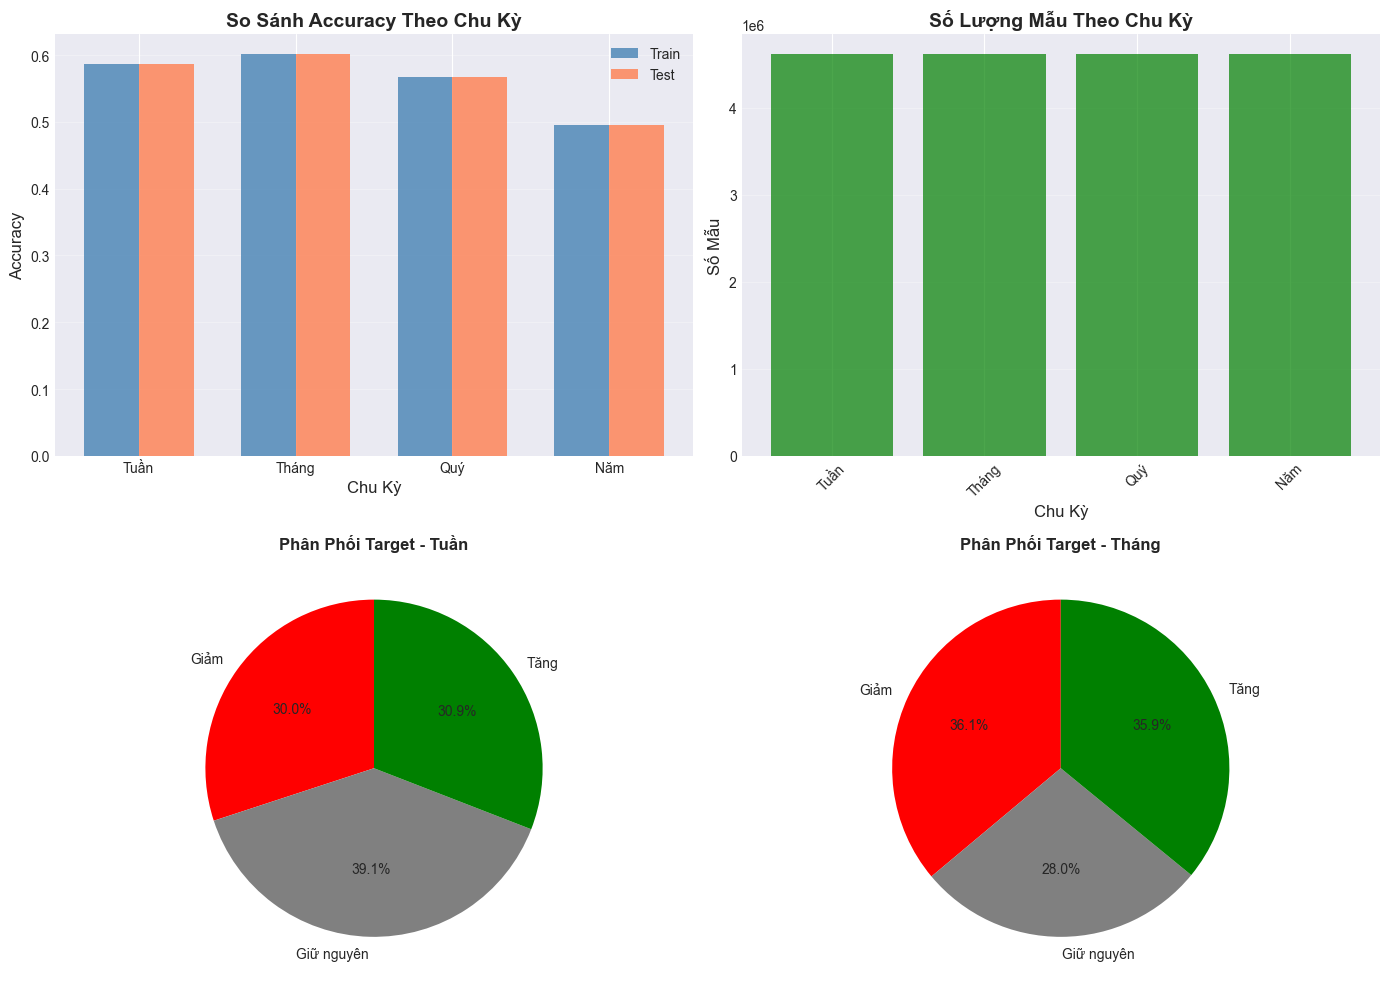


💡 Nhận Xét:
  - Chu kỳ ngắn hơn (tuần, tháng) có nhiều mẫu hơn nhưng có thể khó dự đoán hơn
  - Chu kỳ dài hơn (quý, năm) có ít mẫu hơn nhưng biến động lớn hơn, dễ phân loại hơn
  - Accuracy có thể khác nhau tùy thuộc vào tính chất của từng chu kỳ


In [42]:
# So sánh kết quả giữa các chu kỳ
print("=" * 60)
print("📊 SO SÁNH KẾT QUẢ THEO CHU KỲ")
print("=" * 60)

# Tạo bảng so sánh
comparison_data = []
for cycle_name, result in results_by_cycle.items():
    comparison_data.append({
        'Chu Kỳ': cycle_name,
        'Số Mẫu': result['n_samples'],
        'Train Size': result['n_train'],
        'Test Size': result['n_test'],
        'Train Accuracy': f"{result['train_accuracy']:.4f} ({result['train_accuracy']*100:.2f}%)",
        'Test Accuracy': f"{result['test_accuracy']:.4f} ({result['test_accuracy']*100:.2f}%)"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))

# Visualization
if len(results_by_cycle) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    # 1. Accuracy comparison
    cycle_names = list(results_by_cycle.keys())
    train_accs = [results_by_cycle[c]['train_accuracy'] for c in cycle_names]
    test_accs = [results_by_cycle[c]['test_accuracy'] for c in cycle_names]
    
    x = np.arange(len(cycle_names))
    width = 0.35
    
    axes[0].bar(x - width/2, train_accs, width, label='Train', alpha=0.8, color='steelblue')
    axes[0].bar(x + width/2, test_accs, width, label='Test', alpha=0.8, color='coral')
    axes[0].set_xlabel('Chu Kỳ', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('So Sánh Accuracy Theo Chu Kỳ', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(cycle_names)
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # 2. Sample size comparison
    sample_sizes = [results_by_cycle[c]['n_samples'] for c in cycle_names]
    axes[1].bar(cycle_names, sample_sizes, color='green', alpha=0.7)
    axes[1].set_xlabel('Chu Kỳ', fontsize=12)
    axes[1].set_ylabel('Số Mẫu', fontsize=12)
    axes[1].set_title('Số Lượng Mẫu Theo Chu Kỳ', fontsize=14, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].tick_params(axis='x', rotation=45)
    
    # 3. Target distribution cho từng chu kỳ
    for idx, (cycle_name, result) in enumerate(results_by_cycle.items()):
        if idx >= 2:
            break
        target_dist = pd.Series(result['y_test']).value_counts().sort_index()
        axes[2 + idx].pie(
            target_dist.values,
            labels=[target_labels[i] for i in target_dist.index],
            autopct='%1.1f%%',
            startangle=90,
            colors=['red', 'gray', 'green']
        )
        axes[2 + idx].set_title(f'Phân Phối Target - {cycle_name}', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 Nhận Xét:")
    print("  - Chu kỳ ngắn hơn (tuần, tháng) có nhiều mẫu hơn nhưng có thể khó dự đoán hơn")
    print("  - Chu kỳ dài hơn (quý, năm) có ít mẫu hơn nhưng biến động lớn hơn, dễ phân loại hơn")
    print("  - Accuracy có thể khác nhau tùy thuộc vào tính chất của từng chu kỳ")


In [41]:
print("=" * 60)
print("📊 TỔNG KẾT")
print("=" * 60)

print(f"\n✅ Model: Logistic Regression với Softmax (Multinomial)")
print(f"✅ Số lượng features: {len(feature_cols)}")
print(f"✅ Số lượng mẫu train: {len(X_train):,}")
print(f"✅ Số lượng mẫu test: {len(X_test):,}")

print(f"\n📈 Hiệu Suất:")
print(f"  - Train Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"  - Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

print(f"\n📊 Phân Phối Target:")
for target_val, count in target_counts.items():
    pct = count / len(df_features) * 100
    print(f"  - {target_labels[target_val]}: {pct:.2f}%")

print(f"\n💡 Kết Luận:")
print(f"  - Model đã được train thành công với {len(feature_cols)} features")
print(f"  - Test accuracy: {test_accuracy*100:.2f}%")
print(f"  - Model có thể phân loại xu hướng giá đóng cửa: Tăng/Giảm/Giữ nguyên")
print(f"  - Các features quan trọng nhất: {', '.join([f[0] for f in sorted_features[:5]])}")

print(f"\n⚠️  Lưu ý:")
print(f"  - Đây là mô hình phân loại, không phải dự đoán giá trị cụ thể")
print(f"  - Accuracy có thể bị ảnh hưởng bởi class imbalance")
print(f"  - Có thể cải thiện bằng cách điều chỉnh threshold, thêm features, hoặc dùng model phức tạp hơn")


📊 TỔNG KẾT

✅ Model: Logistic Regression với Softmax (Multinomial)
✅ Số lượng features: 25
✅ Số lượng mẫu train: 3,688,460
✅ Số lượng mẫu test: 922,116

📈 Hiệu Suất:
  - Train Accuracy: 0.9971 (99.71%)
  - Test Accuracy: 0.9971 (99.71%)

📊 Phân Phối Target:
  - Giảm: 27.52%
  - Giữ nguyên: 45.42%
  - Tăng: 27.06%

💡 Kết Luận:
  - Model đã được train thành công với 25 features
  - Test accuracy: 99.71%
  - Model có thể phân loại xu hướng giá đóng cửa: Tăng/Giảm/Giữ nguyên
  - Các features quan trọng nhất: return_1d, rs, price_ma10_ratio, upper_shadow, body

⚠️  Lưu ý:
  - Đây là mô hình phân loại, không phải dự đoán giá trị cụ thể
  - Accuracy có thể bị ảnh hưởng bởi class imbalance
  - Có thể cải thiện bằng cách điều chỉnh threshold, thêm features, hoặc dùng model phức tạp hơn
